In [16]:
import pandas as pd
import numpy as np
import os
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from sklearn.cluster import KMeans, Birch
from sklearn.mixture import GaussianMixture
from sklearn.cluster import SpectralClustering
import matplotlib.pyplot as plt
from dotenv import load_dotenv
from pymongo.mongo_client import MongoClient
from pymongo.server_api import ServerApi
from pymongo import MongoClient
from fastdtw import fastdtw
from sklearn.metrics import silhouette_score
from itertools import product
import warnings
warnings.filterwarnings("ignore")

In [17]:
def graficar_clusters(curves_data, labels, n=5):
    unique_clusters = np.unique(labels)
    
    # Crear una figura con el número de subgráficos correspondientes al número de clústeres
    fig, axes = plt.subplots(len(unique_clusters), 1, figsize=(8, 3.5 * len(unique_clusters)), sharex=True)
    
    if len(unique_clusters) == 1:
        axes = [axes]  # Si solo hay un clúster, hacer que axes sea iterable para mantener el formato
    
    # Para cada clúster, graficar las curvas
    for idx, cluster in enumerate(unique_clusters):
        # Seleccionar las curvas pertenecientes al clúster
        curvas_cluster = curves_data[labels == cluster]

        # Tomar hasta 'n' curvas para graficar
        curvas_a_graficar = curvas_cluster[:min(n, len(curvas_cluster))]
        
        for curva in curvas_a_graficar:
            axes[idx].plot(curva, alpha=0.7, linestyle='--')  # Graficar cada curva con transparencia

        axes[idx].set_title(f'Curvas agrupadas en el Clúster {cluster}')
        axes[idx].set_xlabel('Hora del día')
        axes[idx].set_ylabel('Potencia aparente escalada')
        axes[idx].set_yticks(np.arange(0, 1, 0.1))
        axes[idx].grid(True)

    plt.tight_layout()  # Ajustar el diseño para evitar solapamientos
    plt.show()

def graficar_curva_tipo_cluster(curves_data, labels):
    unique_clusters = np.unique(labels)
    
    # Crear una figura con el número de subgráficos correspondientes al número de clústeres
    fig, axes = plt.subplots(len(unique_clusters), 1, figsize=(8, 3.5 * len(unique_clusters)), sharex=True)
    
    if len(unique_clusters) == 1:
        axes = [axes]  # Si solo hay un clúster, hacer que axes sea iterable para mantener el formato

    # Para cada clúster, graficar la curva media
    for idx, cluster in enumerate(unique_clusters):
        # Seleccionar las curvas pertenecientes al clúster
        curvas_cluster = curves_data[labels == cluster]

        # Calcular la curva media
        curva_media = np.mean(curvas_cluster, axis=0)

        axes[idx].plot(curva_media, linestyle=None, marker='.')  # Graficar la curva media

        axes[idx].set_title(f'Curva tipo para clientes agrupados en clúster {cluster}')
        axes[idx].set_xlabel('Hora del día')
        axes[idx].set_ylabel('Potencia aparente escalada')
        axes[idx].set_yticks(np.arange(0, 1, 0.1))
        axes[idx].grid(True)

    plt.tight_layout()  # Ajustar el diseño para evitar solapamientos
    plt.show()

In [19]:
def obtener_cliente_db():
    # Cargar las variables del archivo .env
    load_dotenv()

    # Obtener las credenciales y el cluster de MongoDB
    username = os.getenv("DB_USER_T")
    password = os.getenv("DB_PASS_T")
    cluster = os.getenv("DB_CLUSTER_T")

    # Construir la uri con las credenciales
    uri = f"mongodb+srv://{username}:{password}@{cluster.lower()}.gypwd.mongodb.net/?retryWrites=true&w=majority&appName={cluster}"

    # Crear un cliente y conectarlo al servidor
    client = MongoClient(uri, 
                        server_api=ServerApi('1'),
                        connectTimeoutMS=60000,
                        socketTimeoutMS=60000,
                        serverSelectionTimeoutMS=60000,
                        tls=True)

    # Si el cliente existe, retornarlo
    if client is not None:
        return client

In [20]:
def ajustar_curva_al_origen(datos_curvas):

    # Crear una copia del arreglo original de las curvas
    curvas_ajustadas = datos_curvas.copy()

    # Iterar sobre cada curva
    for curva in curvas_ajustadas:
        # Obtener el primer dato de cada curva
        primer_dato = curva[0]

        # Modificar los datos de la curva para que el primero siempre empiece en (0,0)
        for i in range(len(curva)):
            curva[i] = curva[i] - primer_dato

    # Retornar todas las curvas con el ajuste realizado
    return curvas_ajustadas

In [21]:
def evaluate_clustering_models(data, param_grid):
    best_models = {}
    results = []

    for model_name, params in param_grid.items():
        param_combinations = list(product(*params.values()))
        param_keys = list(params.keys())

        best_score = -1
        best_params = None
        best_model = None

        for param_set in param_combinations:
            param_dict = dict(zip(param_keys, param_set))

            # Crear el modelo según su tipo
            if model_name == "KMeans":
                model = KMeans(**param_dict, random_state=41)
            elif model_name == "GaussianMixture":
                model = GaussianMixture(**param_dict, random_state=41)
            elif model_name == "BIRCH":
                model = Birch(**param_dict)
            elif model_name == "SpectralClustering":
                model = SpectralClustering(**param_dict, random_state=41)

            # Entrenar el modelo y obtener etiquetas
            try:
                labels = model.fit_predict(data)

                # Evaluar con Silhouette Score
                score = silhouette_score(data, labels)

                # Guardar resultados
                results.append((model_name, param_dict, score))

                # Actualizar mejor modelo de este tipo
                if score > best_score:
                    best_score = score
                    best_params = param_dict
                    best_model = model

            except:
                continue  # Si hay error, seguimos con la siguiente combinación

        # Guardar el mejor modelo para este tipo
        best_models[model_name] = {"model": best_model, "params": best_params, "score": best_score}

    return best_models, results

In [38]:
def elbow_method(data, k_range=(2, 10)):
    inertias = []
    ks = list(range(k_range[0], k_range[1] + 1))

    for k in ks:
        kmeans = KMeans(n_clusters=k, random_state=41, n_init=20, init="k-means++")
        kmeans.fit(data)
        inertias.append(kmeans.inertia_)

    # Graficar
    plt.figure(figsize=(8, 5))
    plt.plot(ks, inertias, marker='o', linestyle='-', color='b')
    plt.xlabel('Número de Clusters (k)')
    plt.ylabel('Inercia')
    plt.title('Método del Codo para Determinar k')
    plt.xticks(ks)
    plt.grid(True)
    plt.show()

    return ks, inertias


### Pruebas con una curva de cada tipo

Ejemplos de cada curva tipo:
- 90001730 1297988  1773847-> Trapecio invertido
- 90001692  1130655  1818407  10048266-> Montañita
- 1044341 1457182  1479849  1807768-> Lineal
- 1122395  1140407  1202633  1867926-> Trapecio

In [22]:
# Obtener cliente para conectar a la db
db_cliente = obtener_cliente_db()

# Obtener los registros de las curvas
cursor = db_cliente.CurvasTipo.CurvasTipo_30m.find({}, {"_id": 0})
df_registros_curvas = pd.DataFrame(list(cursor))
df_registros_curvas

,Cliente,00:00,00:30,01:00,01:30,02:00,02:30,03:00,03:30,04:00,...,19:00,19:30,20:00,20:30,21:00,21:30,22:00,22:30,23:00,23:30
0,1573720,0.363002,0.331695,0.326874,0.325933,0.323621,0.321635,0.321419,0.316180,0.312310,...,0.449903,0.432212,0.416207,0.403184,0.389191,0.386608,0.382731,0.377707,0.372261,0.366060
1,1105013,0.005635,0.005638,0.005625,0.005599,0.005641,0.005603,0.005723,0.005566,0.005681,...,0.013831,0.018898,0.013625,0.007781,0.006178,0.005663,0.005631,0.005546,0.005522,0.005591
2,1526607,0.013584,0.009704,0.011413,0.011141,0.011416,0.011610,0.013109,0.014883,0.014283,...,0.152618,0.109653,0.076575,0.067731,0.059837,0.055541,0.044980,0.036912,0.026697,0.018961
3,730664,0.082170,0.062268,0.063056,0.064055,0.064957,0.065565,0.065585,0.065628,0.066157,...,0.250105,0.229761,0.216083,0.210663,0.204582,0.179754,0.159204,0.118550,0.086001,0.085839
4,1627579,0.411751,0.369310,0.363768,0.328309,0.304045,0.280685,0.300073,0.316729,0.354909,...,0.417470,0.417692,0.420252,0.414043,0.411301,0.408581,0.412699,0.419369,0.414996,0.411478
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
382,PLANTAS TECNICAS PLANTEC,0.743419,0.736625,0.733471,0.725601,0.724044,0.724137,0.722159,0.721879,0.721760,...,0.752499,0.761647,0.759183,0.759199,0.757987,0.754864,0.748818,0.746688,0.747010,0.745319
383,PLASTISACKS (Punto 2),0.398338,0.386867,0.396070,0.395888,0.394678,0.381221,0.378709,0.384696,0.385036,...,0.344806,0.339009,0.383922,0.394191,0.385541,0.391837,0.393133,0.388121,0.385626,0.393935
384,PROVEFARMA - FYBECA,0.632775,0.520884,0.459899,0.419739,0.378865,0.351146,0.332676,0.313714,0.308495,...,0.768608,0.774897,0.769014,0.776480,0.767294,0.745386,0.729979,0.714406,0.710694,0.705524
385,SOCIEDAD INDUSTRIAL RELI CYRANO,0.522447,0.533413,0.594090,0.619295,0.542844,0.474003,0.453784,0.474405,0.424981,...,0.228917,0.220160,0.220309,0.217405,0.226077,0.253856,0.331315,0.413486,0.496200,0.534456


In [23]:
curves_data = df_registros_curvas.iloc[:,1:].values
curves = df_registros_curvas.values

In [24]:
curvas_ajustadas_origen = ajustar_curva_al_origen(curves_data)

### Grid Search para buscar los mejores parámetros para cada modelo

In [96]:
# Definir los hiperparámetros a probar por cada algoritmo de agrupación
param_grid = {
    "KMeans": {
        "n_clusters": [4,5,6],
        "init": ["k-means++", "random"],
        "n_init": [10, 20, 30]
    },
    "GaussianMixture": {
        "n_components": [4,5,6],
        "covariance_type": ["full", "diag"],
        "n_init": [1, 5, 10, 20]
    },
    "BIRCH": {
        "n_clusters": [4,5,6],
        "threshold": [0.05, 0.2, 0.3, 0.4, 0.45, 0.5, 0.55,0.6, 1.0],
        "branching_factor": [10, 20, 50, 100]
    },
    "SpectralClustering": {
        "n_clusters": [4,5,6],
        "affinity": ["nearest_neighbors", "rbf"],
        "n_neighbors": [5, 10, 15, 25, 35, 50, 60, 70 ,80, 90, 100],
        "eigen_solver": ["arpack", "lobpcg", "amg"]
    }
}


In [108]:
from itertools import product
from sklearn.cluster import KMeans, SpectralClustering, Birch
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

def evaluate_clustering_models(data, param_grid):
    best_models = {}
    results = []

    for model_name, params in param_grid.items():
        param_combinations = list(product(*params.values()))
        param_keys = list(params.keys())

        best_score = -1
        best_params = None
        best_model = None

        for param_set in param_combinations:
            param_dict = dict(zip(param_keys, param_set))

            # Crear el modelo según su tipo
            if model_name == "KMeans":
                model = KMeans(**param_dict, random_state=41)
            elif model_name == "GaussianMixture":
                model = GaussianMixture(**param_dict, random_state=41)
            elif model_name == "BIRCH":
                model = Birch(**param_dict)
            elif model_name == "SpectralClustering":
                model = SpectralClustering(**param_dict, random_state=41)

            # Entrenar el modelo y obtener etiquetas
            try:
                labels = model.fit_predict(data)

                # Calcular métricas
                silhouette = silhouette_score(data, labels)
                calinski_harabasz = calinski_harabasz_score(data, labels)
                davies_bouldin = davies_bouldin_score(data, labels)

                # Guardar resultados
                results.append((model_name, param_dict, silhouette, calinski_harabasz, davies_bouldin))

                # Actualizar mejor modelo basado en Silhouette Score (puedes cambiar este criterio)
                if davies_bouldin > best_score:
                    best_score = davies_bouldin
                    best_params = param_dict
                    best_model = model

            except:
                continue  # Si hay error, seguimos con la siguiente combinación

        # Guardar el mejor modelo para este tipo
        best_models[model_name] = {
            "model": best_model,
            "params": best_params,
            "silhouette_score": best_score
        }

    return best_models, results


In [109]:
best_models, results = evaluate_clustering_models(curves_data, param_grid)


In [119]:

for model_name, info in best_models.items():
    print(f"🏆 Mejor configuración para {model_name}:")
    print(f"📌 Parámetros: {info['params']}")
    print(f"📊 Silhouette Score: {info['silhouette_score']:.4f}")
    print("-" * 50)


🏆 Mejor configuración para KMeans:
📌 Parámetros: {'n_clusters': 5, 'init': 'random', 'n_init': 20}
📊 Silhouette Score: 1.1610
--------------------------------------------------
🏆 Mejor configuración para GaussianMixture:
📌 Parámetros: {'n_components': 4, 'covariance_type': 'full', 'n_init': 5}
📊 Silhouette Score: 3.8854
--------------------------------------------------
🏆 Mejor configuración para BIRCH:
📌 Parámetros: {'n_clusters': 6, 'threshold': 0.4, 'branching_factor': 100}
📊 Silhouette Score: 1.3555
--------------------------------------------------
🏆 Mejor configuración para SpectralClustering:
📌 Parámetros: {'n_clusters': 6, 'affinity': 'nearest_neighbors', 'n_neighbors': 60, 'eigen_solver': 'lobpcg'}
📊 Silhouette Score: 1.1967
--------------------------------------------------


### Confirmar número óptimo de clústers con el método del codo

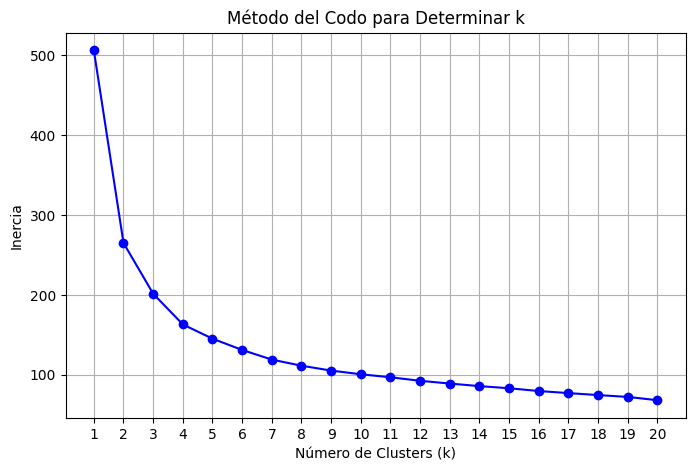

In [111]:
ks, inertias = elbow_method(curvas_ajustadas_origen, k_range=(1, 20))

### Observar las curva tipo por cada algoritmo y clúster

In [120]:
def apply_clustering(distance_matrix, n_clusters=4, num_random_state=41):
    # Función para aplicar clustering
    kmeans = KMeans(n_clusters=5,init='k-means++', n_init=20,random_state=num_random_state).fit(distance_matrix)
    gmm = GaussianMixture(n_components=n_clusters, random_state=num_random_state, covariance_type="full", n_init=1).fit(distance_matrix)
    birch = Birch(n_clusters=6, threshold=0.4, branching_factor=100).fit(distance_matrix)
    spectral = SpectralClustering(n_clusters=6, random_state=num_random_state, eigen_solver="lobpcg", affinity="nearest_neighbors", assign_labels='kmeans', n_neighbors=60).fit(distance_matrix)
    
    return {
        'KMeans': kmeans.labels_,
        'GaussianMixture': gmm.predict(distance_matrix),
        'Birch': birch.labels_,
        'Spectral': spectral.labels_
    }

In [121]:
clusters = apply_clustering(curvas_ajustadas_origen)

In [122]:
print(np.bincount(clusters["KMeans"]))
print(np.bincount(clusters["GaussianMixture"]))
print(np.bincount(clusters["Birch"]))
print(np.bincount(clusters["Spectral"]))

[ 84 112  15 135  41]
[ 45 218  19 105]
[ 13 153  46 151   2  22]
[70 70 59 64 54 70]


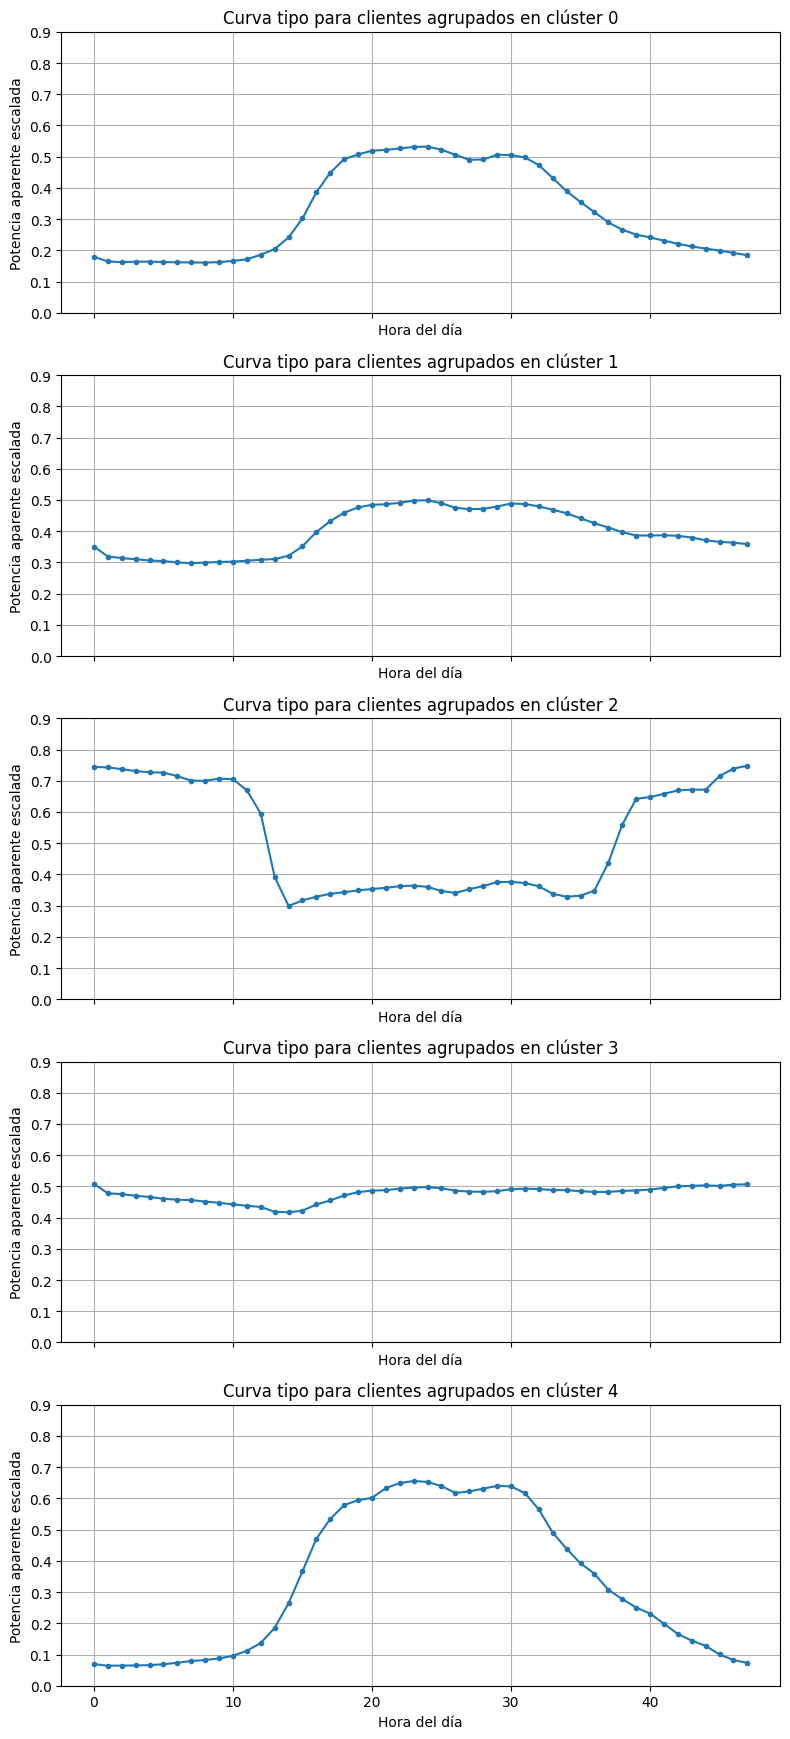

In [123]:
graficar_curva_tipo_cluster(curves_data, clusters["KMeans"])

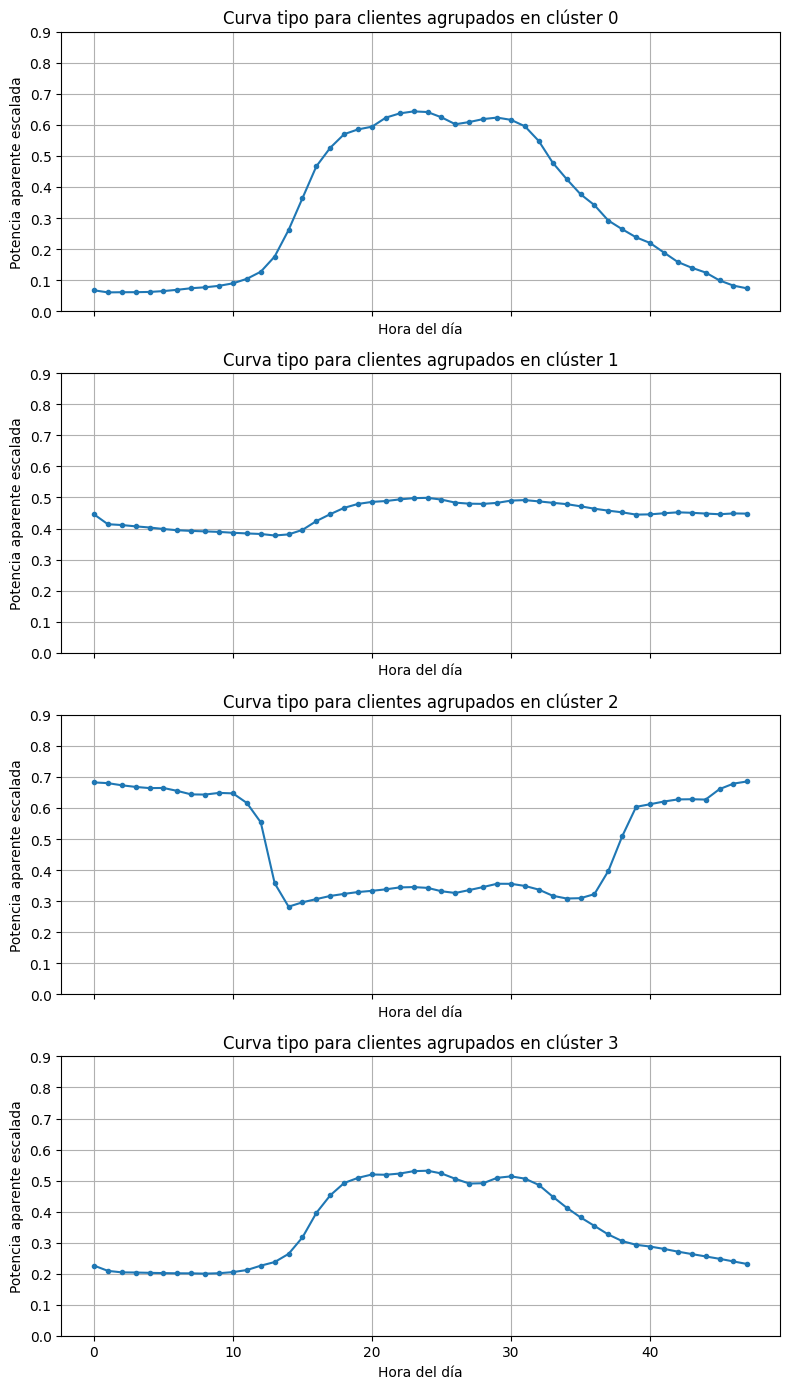

In [124]:
graficar_curva_tipo_cluster(curves_data, clusters["GaussianMixture"])

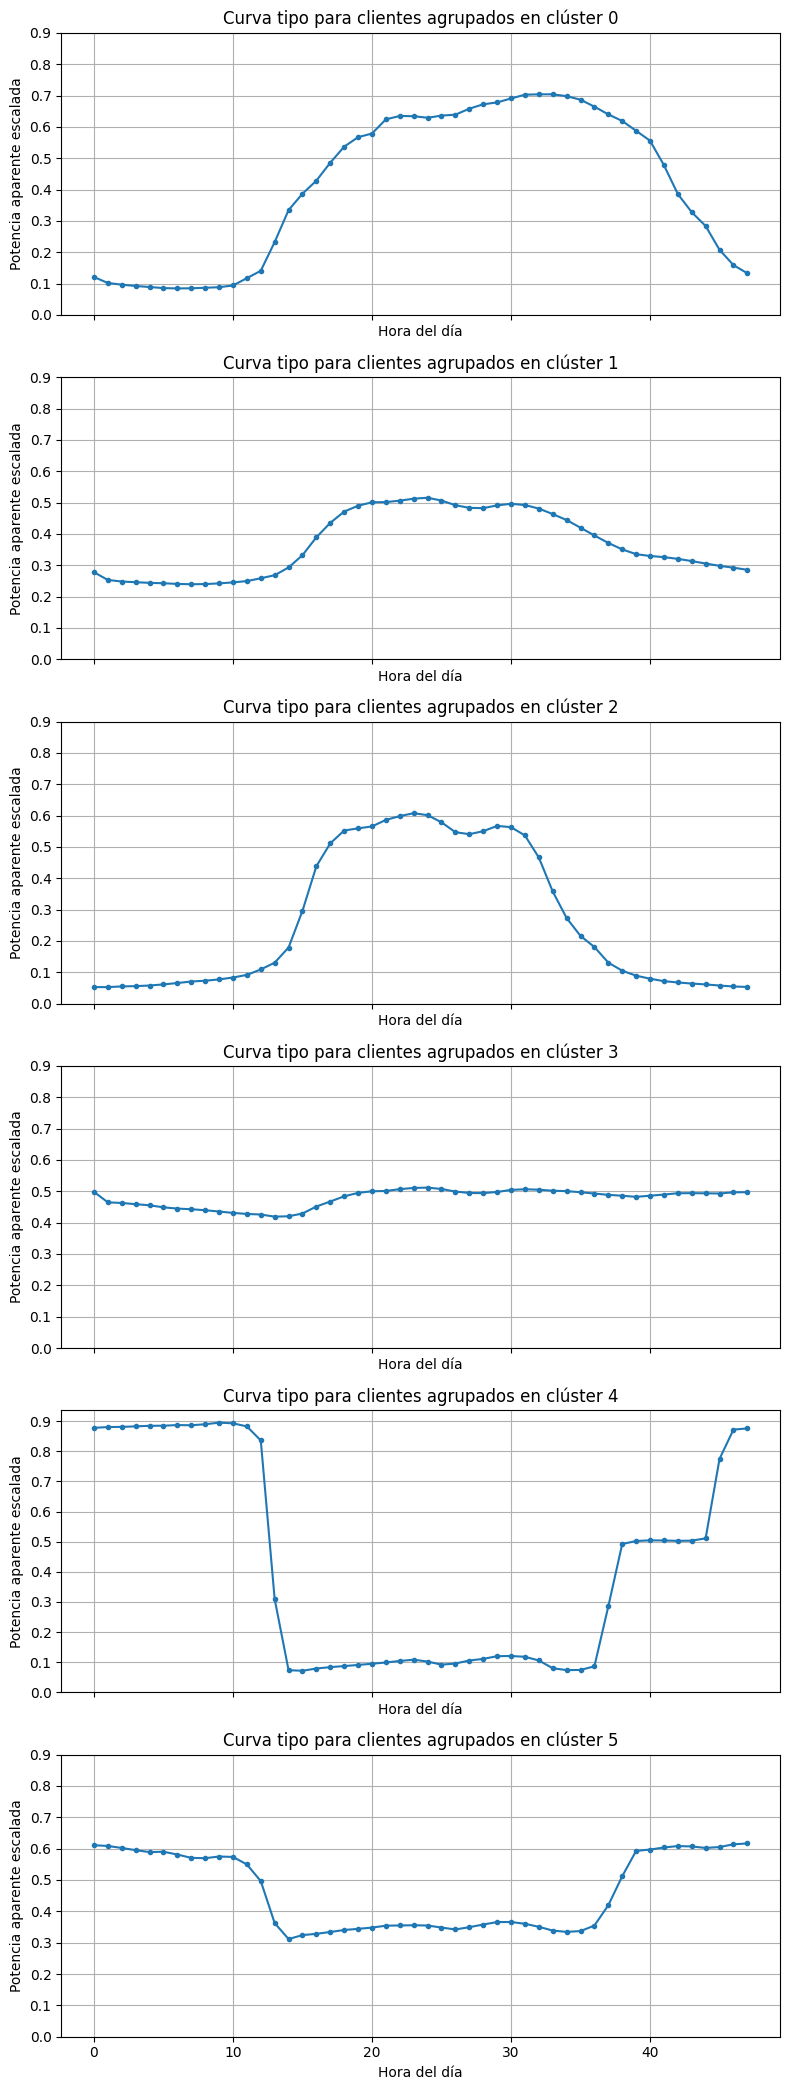

In [125]:
graficar_curva_tipo_cluster(curves_data, clusters["Birch"])

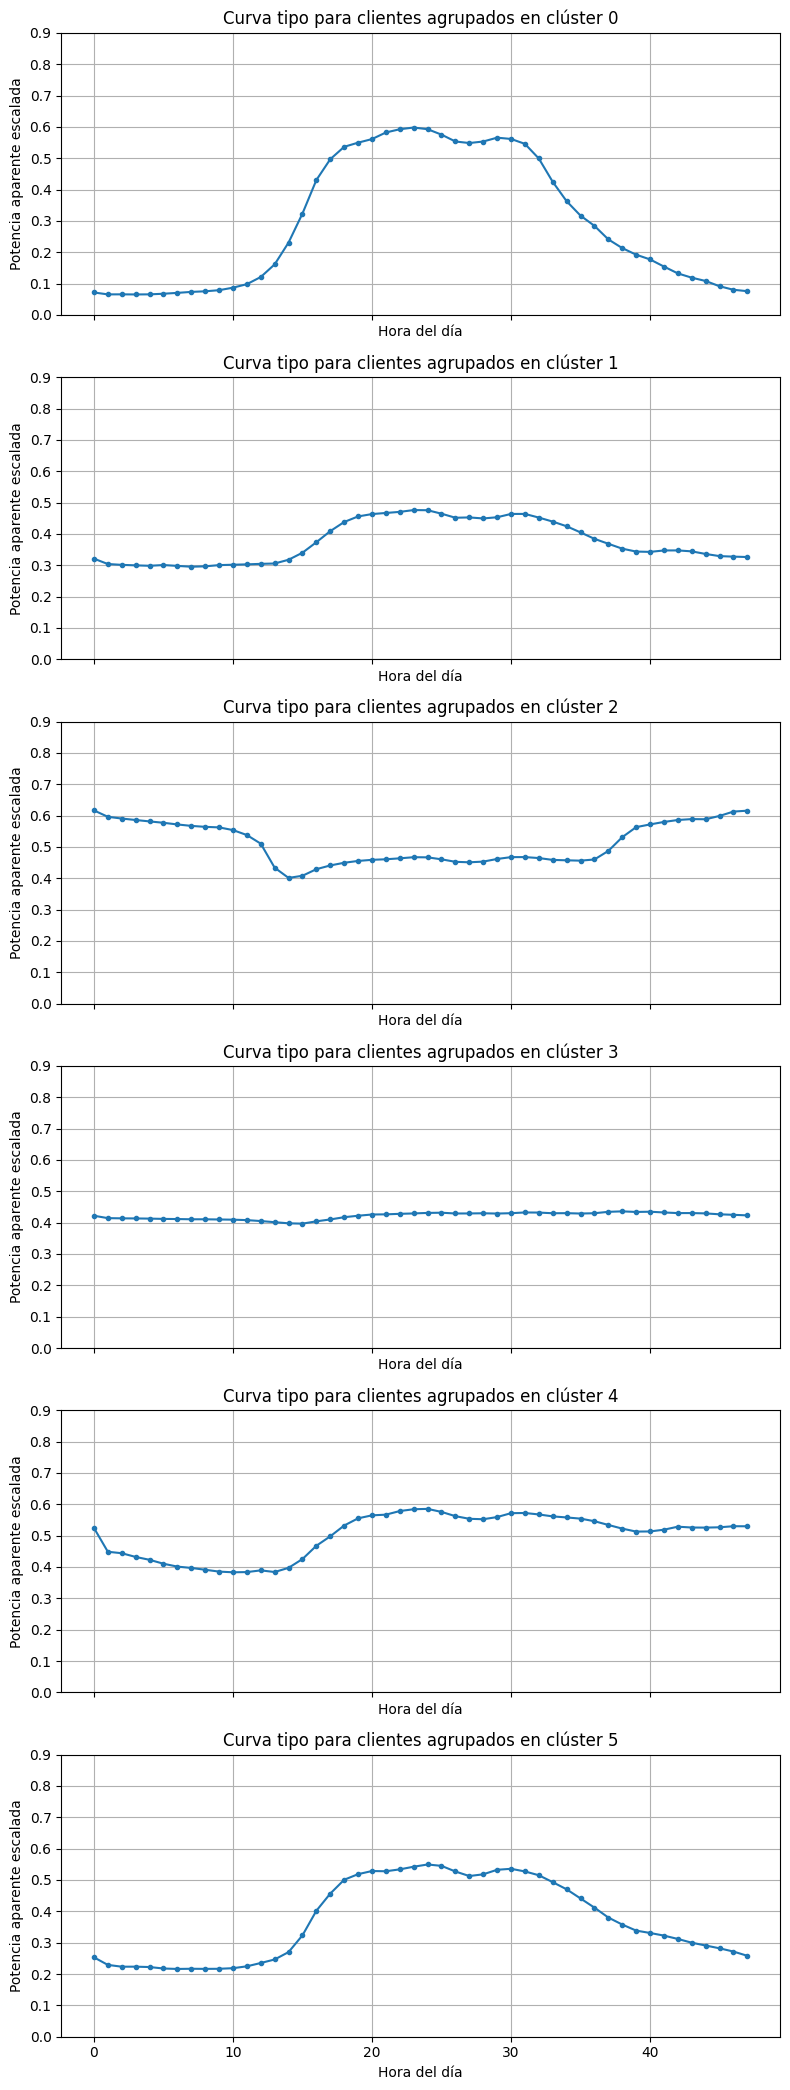

In [126]:
graficar_curva_tipo_cluster(curves_data, clusters["Spectral"])